In [26]:
# Install dependencies
install.packages("tiff")

# load the 'tiff' library
library(tiff)
library(hsdar)

# set the file path to the TIFF file
file_path <- "100fps_80px/hvc 0120.tif"

# read in the TIFF file
tiff_file <- readTIFF(file_path)

# convert the TIFF file to a matrix
matrix_data <- t(as.matrix(tiff_file))

# check the dimensions of the matrix
dim(matrix_data)


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



[1]  80 256

### Information from the hsdar manual

the Speclib contains spectra, wavelengths, supplementary data (SI, optional) and some metadata (optional). The spectra are stored in a matrix with the spectral bands organized in columns and the different samples (or pixels) organized in rows. Alternatively, it is possible to use a RasterBrick- object to store the spectra. The vector ”wavelength” indicates the corresponding wave- length of each band.

Speclibs can be created in different ways. To build a Speclib you need at least spectra and the corresponding wavelength values. The easiest way is to prepare a matrix of your spectra. This matrix must be organized in the way that each row represents one sample and each column represents a spectral band.

In [27]:
# Load some example data to inspect
data(spectral_data) #Load the data used in the tutorial

spectra <- spectra(spectral_data)

str(spectra)

# wavelength <- wavelength(spectral_data)
# str(wavelength)

# str(spectral_data)

# str(matrix_data)
spectra <- matrix_data
# create a vector of 256 evenly spaced values between 400 and 1700
wavelength <- seq(400, 1700, length.out = dim(matrix_data)[2])

# Make the new SpecLib
simpleSpecLib <- speclib(spectra, wavelength)
simpleSpecLib
# Add IDs for each pixel
pixel_num <- seq(1, dim(matrix_data)[1])
idSpeclib(simpleSpecLib) <- as.character(pixel_num)
simpleSpecLib




 num [1:45, 1:1401] 6.52 7.01 7.25 6.74 7.52 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : NULL


Summary of Speclib


Summary of spectra
---------------------
Total number of spectra : 80
Number of bands : 256
Mean width of bands : 5.1 nm
Spectral range of data : 400 - 1700 nm

Summary of Speclib


Summary of spectra
---------------------
Total number of spectra : 80
Number of bands : 256
Mean width of bands : 5.1 nm
Spectral range of data : 400 - 1700 nm

In [28]:
## Example of predefined filter functions
## Savitzky-Golay
sgolay <- noiseFiltering(simpleSpecLib, method="sgolay", n=25)




### More from the docs
Speclibs can easily be plotted using the plot.speclib function. The default way is to plot mean values (solid line) of all spectra in the Speclib and the standard deviations within bands. If the data are continuous the standard deviations are plotted as dashed lines otherwise error bars will indicate standard deviations. You can also plot single spectra by adapting the FUN parameter to the ID of the spectra to be plotted. Also, you can use a function as FUN parameter like e.g. the median or mean spectrum. See some examples below:
```
> par(mfrow = c(2,2))
> plot(spectral_data, main = "Default Plot")
> plot(spectral_data, FUN = 1, main = "First spectrum of Speclib")
> plot(spectral_data, FUN = "median", main = "Median spectrum")
> plot(spectral_data, FUN = "mean", main = "Mean spectrum")
```

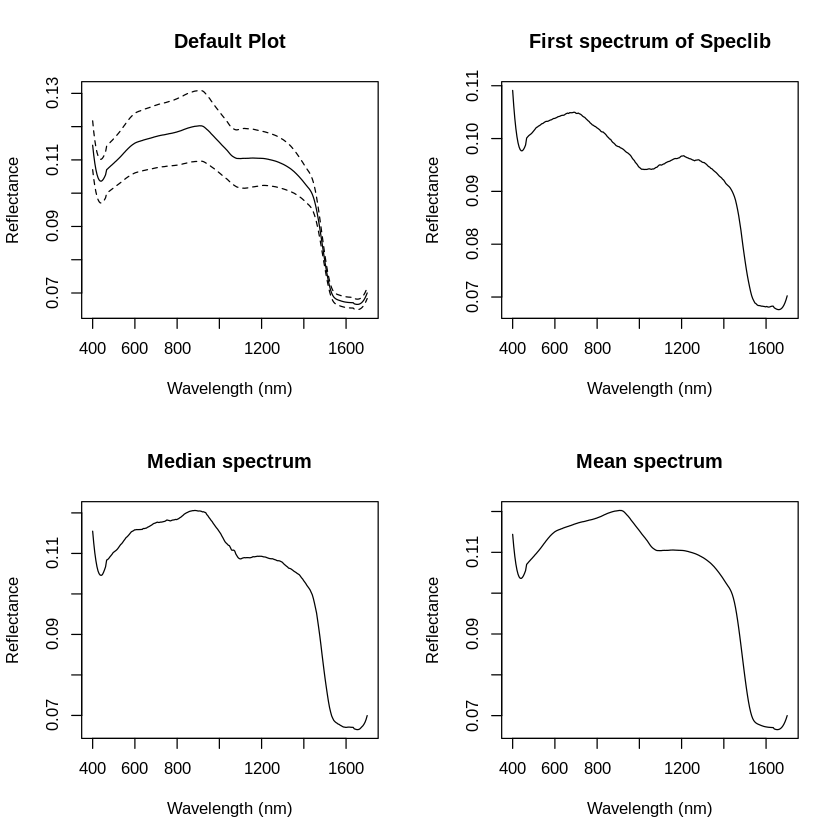

In [29]:

par(mfrow = c(2,2))
plot(sgolay, main = "Default Plot")
plot(sgolay, FUN = 1, main = "First spectrum of Speclib")
plot(sgolay, FUN = "median", main = "Median spectrum")
plot(sgolay, FUN = "mean", main = "Mean spectrum")

## Relevant issues in the package

### Mask
Usually, there are parts in the spectrum which are associated with errors or which are simply not of interest. hsdar allows you to mask these parts so that they don’t appear in further analysis any more. In ”spectral data”, the areas between 1040 and 1060 nm are errors due to channel crossing of the spectrometer and the wavelengths 1300 to 1450 are affected by water absorption. These areas should be masked in the following. There are several ways of how to enter the lower and upper limits of the wavelengths to be masked. For example you can set these values from a vector which simply consists of a sequence of lower and upper wavelengths. All wavelength between lower and upper wavelength are then masked. See ?mask for further options of how to specify these values.
```
> spectral_data_masked <- spectral_data
> mask(spectral_data_masked) <- c(1040,1060,1300,1450) >#
> #plot results:
> par(mfrow = c(1,2))
> plot(spectral_data, FUN = 1)
> plot(spectral_data_masked, FUN = 1)
))
```

Beside of masking these wavelength you can also assign ”new” values to them by linear interpolation. Note that interpolation is not working if start or end point of the whole spectrum were masked.
```
> spectral_data_interpolated <- interpolate.mask(spectral_data_masked)
> plot(spectral_data_interpolated, FUN = 1)
```

### Filtering

hsdar implements several methods to smooth spectra. These are Savitzky-Golay, Spline, locally weighted scatterplot smoothing (Lowess) and Mean-filter. noiseFiltering needs a Speclib as input and the method to be used. Depending on the method there are further parameters to be set. Have a look on the hsdar help to find more information on these additional parameters.
```
>#
> #Filter Speclib:
>#
> sgolay <- noiseFiltering(spectral_data, method = "sgolay", n = 25) > lowess <- noiseFiltering(spectral_data, method = "lowess", f = .01) > meanflt <- noiseFiltering(spectral_data, method = "mean", p = 5)
> spline <- noiseFiltering(spectral_data, method = "spline",
+ n = round(nbands(spectral_data)/10, 0))
Now plot the results:
> par(mfrow = c(2,2))
> plot(sgolay, FUN = 1, subset = c(1200,1300), col = "red",
+      main = "Savitzky-Golay-Filter")
> plot(spectral_data, FUN = 1, new = FALSE) #raw spectrum
> plot(lowess, FUN = 1, subset = c(1200,1300), col = "red",
23
    
+      main = "Lowess-Filter")
> plot(spectral_data, FUN = 1, new = FALSE) #raw spectrum
> plot(meanflt, FUN = 1, subset = c(1200,1300), col = "red",
+      main = "Mean-filter")
> plot(spectral_data, FUN = 1, new = FALSE) #raw spectrum
> plot(spline, FUN = 1, subset = c(1200,1300), col = "red",
+      main = "Spline-Filter")
> plot(spectral_data, FUN = 1, new = FALSE) #raw spectrum

```

### Continuum removal
Continuum removal is a commonly used method in hyperspectral remote sensing to nor- malize spectra and to detect and ensure the comparability of absorption features The con- tinuum removal transformation is performed by firstly establishing a continuum line/hull which connects the local maxima of the reflectance spectrum. Two kinds of this hull are well established in scientific community: the convex hull (e.g. Mutanga and Skidmore (2004a)) and the segmented hull (e.g. Clark et al. (1987)). Both hulls are established by connecting the local maxima, however, the precondition of the convex hull is that the resulting continuum line must be convex whereas considering the segmented hull it might be concave or convex but the algebraic sign of the slope is not allowed to change from the global maximum of the spectrum downwards to the sides. In contrast to a convex hull, the segmented hull is able to identify small absorption features.
Because the continuum removal transformation is sensitive to errors in the spectrum, it’s advisable to first mask erroneous parts of the spectrum. Further you should consider to smooth the spectra very slightly to avoid small local maxima which are not associated with reflection maxima. Read section 5.3 and 5.2 for more details on the preprocessing. For this example we use simulated spectra from the PROSAIL model (see section 4)


```  
> parameter <- data.frame(N = c(0.5,1),LAI = 0.5,Car=3)
> spectra <- PROSAIL(parameterList = parameter)
Then have a look at the transformSpeclib function:
> str(transformSpeclib)
function (data, ..., method = "ch", out = "bd")
```
”data” defines the speclib which is to be transformed. Concerning the ”methods” pa- rameter, currently the mentioned convex hull (”ch”) and the segmented hull (”sh”) are implemented. The ”out” parameter indicates if the continuum line (”raw”), the contin- uum removed spectra (band depth, ”bd”) or the ”ratio” will be returned. Have a look on the help page of transform.speclib and the listed literature for details on these methods or for help with interpretation. The output type of ”ratio” the ”bd” is a speclib, out=”raw” returns an object of ”clman”. ”clman” is a class designed to store and handle manual continuum lines.
The following example will show you how to calculate the continuum line (just for visualization) and the band depth using the convex hull as well as the segmented hull approach:
```
> #convex hull:
> ch_cline <- transformSpeclib(spectra,
+ method = "ch", out = "raw") > ch_bd <- transformSpeclib(spectra,
+ method = "ch", out = "bd")
>#
> #segmented hull:
>#
> sh_cline <- transformSpeclib(spectra,
+ method = "sh", out = "raw") > sh_bd <- transformSpeclib(spectra,
+ method = "sh", out = "bd")
Plot continuum lines and resulting band depths for both methods to see the differences:
> #plot results for the first spectrum:
>#
> par(mfrow = c(2,2))
> plot(ch_cline, ispec = 1, numeratepoints = FALSE, + main = "Convex hull - Continuum line")
> plot(ch_bd, ispec = 1, main = "Convex hull - Band depth")
> plot(sh_cline, ispec = 1, numeratepoints = FALSE,
+      main = "Segmented hull - Continuum line")
> plot(sh_bd, ispec = 1, main = "Segmented hull - Band depth")
```

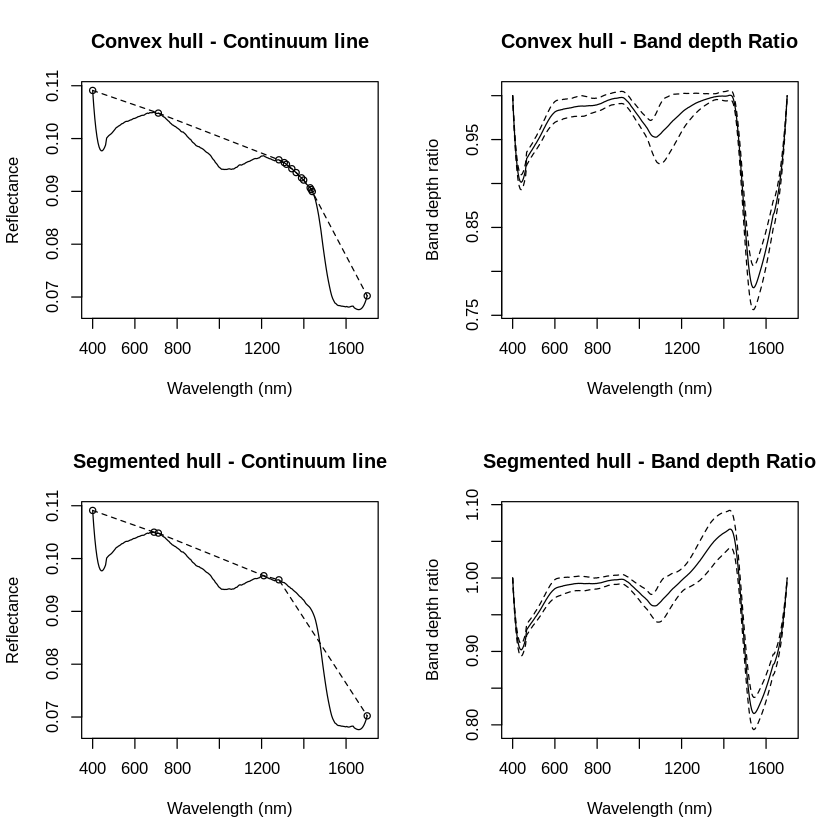

In [30]:
#convex hull:
ch_cline <- transformSpeclib(sgolay,
    method = "ch", out = "raw") 
ch_bd <- transformSpeclib(sgolay,
    method = "ch", out = "ratio")
#
#segmented hull:
#
sh_cline <- transformSpeclib(sgolay,
    method = "sh", out = "raw") 
sh_bd <- transformSpeclib(sgolay,
    method = "sh", out = "ratio")
# Plot continuum lines and resulting band depths for both methods to see the differences:
#plot results for the first spectrum:

par(mfrow = c(2,2))
plot(ch_cline, ispec = 1, numeratepoints = FALSE, 
     main = "Convex hull - Continuum line")
plot(ch_bd, ispec = 1, main = "Convex hull - Band depth Ratio")
plot(sh_cline, ispec = 1, numeratepoints = FALSE,
      main = "Segmented hull - Continuum line")
plot(sh_bd, ispec = 1, main = "Segmented hull - Band depth Ratio")

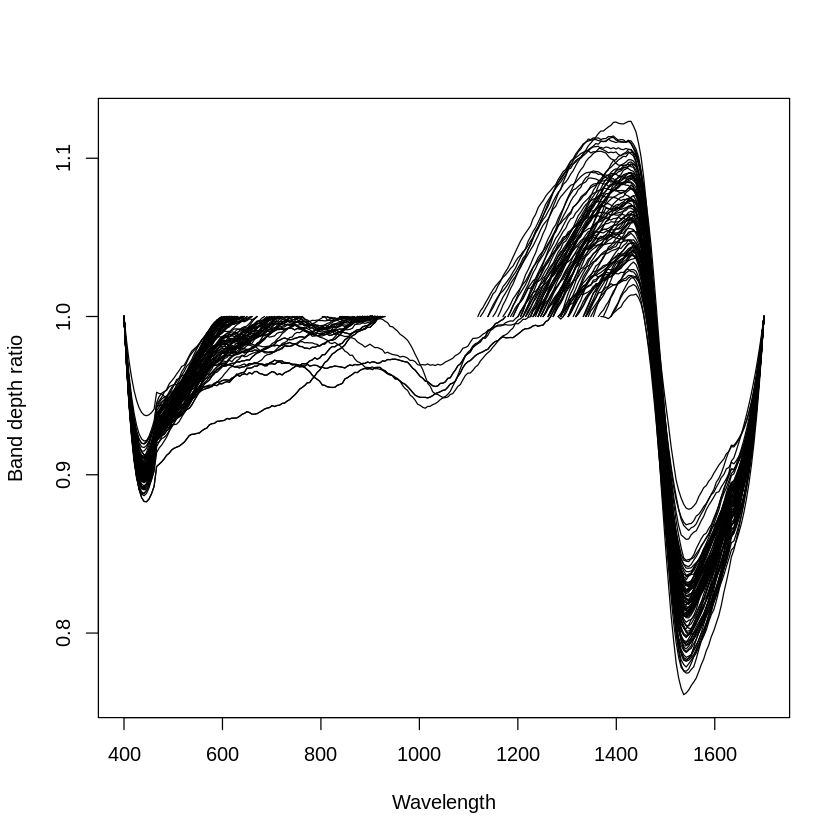

In [31]:
##Example to isolate the features around specific wavelengths.
featureSelection <- specfeat(sh_bd, c(400, 900, 1550))
## Plot features
plot(featureSelection, fnumber= 1:3)

The isolated and cleaned features can then be characterized by calculating e.g. the area of the features. This information can be added to the supplementary information of the speclib, e.g. for a later statistical analysis of the relationships between the size of specific absorption features and vegetation characteristics.

In [21]:
## Calculate properties of features
featureProp <- feature_properties(featureSelection)
## See resulting feature property variables
head(SI(featureProp))

,f400_area,f900_area,f1550_area,f400_maxwl,f900_maxwl,f1550_maxwl,f400_lo_wlhm,f400_up_wlhm,f400_width_wlhm,f400gauss_lo_wlhm,⋯,f900gauss_lo_wlhm,f900gauss_up_wlhm,f1550_lo_wlhm,f1550_up_wlhm,f1550_width_wlhm,f1550gauss_lo_wlhm,f1550gauss_up_wlhm,f400_max,f900_max,f1550_max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,76.99782,10.983896,96.94943,400.0000,914.9020,1424.706,400.0000,440.7843,40.78431,0.3934694,⋯,0.6155526,0.3855866,1200.392,1547.059,346.6667,0.1789530,0.5060924,1,1,1.088387
2,80.96701,4.997910,100.46230,823.1373,884.3137,1419.608,440.7843,823.1373,382.35294,0.4124438,⋯,0.4872600,0.5429722,1185.098,1547.059,361.9608,0.1789176,0.4977956,1,1,1.097970
3,64.18516,3.999520,85.93019,736.4706,899.6078,1434.902,440.7843,736.4706,295.68627,0.4087724,⋯,0.4550542,0.5945209,1251.373,1547.059,295.6863,0.1774795,0.5152608,1,1,1.072378
4,99.72835,99.728347,96.44207,920.0000,920.0000,1434.902,440.7843,920.0000,479.21569,0.4195438,⋯,0.4195438,0.7936722,1205.490,1541.961,336.4706,0.1706205,0.5250877,1,1,1.091960
5,67.27546,2.999212,99.37716,400.0000,904.7059,1429.804,400.0000,440.7843,40.78431,0.3934693,⋯,0.5773505,0.0000000,1190.196,1547.059,356.8627,0.1796111,0.5159342,1,1,1.085546
6,53.61107,8.990683,89.98679,680.3922,879.2157,1434.902,440.7843,680.3922,239.60784,0.4109975,⋯,0.4192501,0.5404042,1230.980,1541.961,310.9804,0.1777289,0.5240516,1,1,1.066260
